# **Use case**

At our foundry, we have been focusing on optimizing various production processes to improve efficiency and performance. Recently, we installed two sensors in the building to monitor key environmental parameters. The data collected from these sensors, especially the values recorded at the start of the day, have shown a strong correlation with the final furnace temperatures by the end of the workday. This discovery has provided valuable insights into how early conditions can influence the overall thermal dynamics of the production process.

Moreover, by analyzing historical data, we have identified certain repetitive trends in the furnace temperature behavior. These patterns suggest that there are consistent factors influencing the furnace operation, and understanding these trends will allow us to better predict and control temperature fluctuations. By leveraging this data, we aim to implement further process improvements, enhancing both productivity and energy efficiency in the foundry.

We are now looking to develop a time-based model that can predict the final furnace temperatures at the end of the day, using the sensor data collected at the beginning of the workday. This predictive model will be trained using the historical data from both the sensors and the actual furnace temperature measurements. By leveraging these datasets, the model will learn to forecast temperature trends and provide accurate predictions, allowing us to better manage and optimize the heating process throughout the day, ultimately improving operational efficiency and reducing energy consumption.

# Collect data
In this notebook, we will simulate the process of data collection from the foundry in order to predict the optimal operating temperatures for the furnaces. Previous analysis has shown a correlation between the values recorded by two sensors in the factory at the start of the day and the temperature reached by the furnaces by the end of the day. We will create three different datasets:
* **historical.csv**: This dataset will serve as a historical record for training the model. It includes the previous data from the two external sensors (*sensor1*, *sensor2*) and the actual measured values (*y*) of the furnace temperatures at the end of the day.
* **sensors_data.csv**: This dataset contains the real-time values captured by the two sensors in the factory (*sensor1*, *sensor2*).
* **measured_value.csv**: This file simulates the actual measured value (*y*) of the furnace temperature at the end of the day. It will be used to compare the real value with the predicted value generated by the model, based on both sensor data and historical records.

In [1]:
# Packages needed for the s3 connection
# ==============================================================================
!pip install boto3


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Imports and configuration for the s3 connection and the plots
# ==============================================================================
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

In [3]:
# Read the data connection variables
# ==============================================================================
key_id = os.getenv("AWS_ACCESS_KEY_ID")
secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
endpoint = os.getenv("AWS_S3_ENDPOINT")
bucket_name = os.getenv("AWS_S3_BUCKET")

In [4]:
# Create the s3 connection
# ==============================================================================
s3_client = boto3.client(
    "s3",
    aws_access_key_id=key_id,
    aws_secret_access_key=secret_key,
    endpoint_url=endpoint,
    use_ssl=True
)

In [5]:
# Create a new folder and download the raw datasets
# ==============================================================================
os.makedirs("data", exist_ok=True)

s3_client.download_file(bucket_name, '/data/historical.csv', 'data/historical.csv')
s3_client.download_file(bucket_name, '/data/sensors_data.csv', 'data/sensors_data.csv')
s3_client.download_file(bucket_name, '/data/measured_value.csv', 'data/measured_value.csv')

In [6]:
# Load the historical dataset
# ==============================================================================
data = pd.read_csv('data/historical.csv')
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

In [7]:
# Select the number of days that will be predicted
# ==============================================================================
days = 1

In [8]:
# Retrieve the sensor values from the raw dataset for the specified number of days.
# ==============================================================================
sensors_data = pd.read_csv('data/sensors_data.csv')
sensors_data = sensors_data.loc[sensors_data.index[:days]]
sensors_data['date'] = pd.to_datetime(sensors_data['date'], format='%Y-%m-%d')
sensors_data = sensors_data.set_index('date')
sensors_data = sensors_data.asfreq('MS')

In [9]:
# Retrieve the real measured value from the raw dataset for the specified number of days. Will be used to compare it with the prediction
# ==============================================================================
measured_value = pd.read_csv('data/measured_value.csv')
measured_value = measured_value.loc[measured_value.index[:days]]
measured_value['date'] = pd.to_datetime(measured_value['date'], format='%Y-%m-%d')
measured_value = measured_value.set_index('date')
measured_value = measured_value.asfreq('MS')

              exog_1    exog_2
date                          
2005-07-01  1.415756  1.446988
                   y
date                
2005-07-01  0.874336


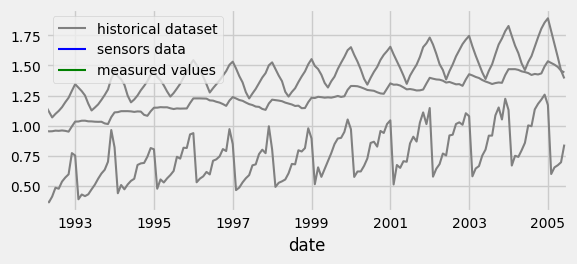

In [10]:
# Plot the three datasets (if the number of days is too low, the values will probably not be visible on the right side of the graph.)
# ==============================================================================
print(sensors_data)
print(measured_value)
fig, ax = plt.subplots(figsize=(6, 2.5))
data['y'].plot(ax=ax, label='historical dataset', color='grey')
data['exog_1'].plot(ax=ax, label='_nolegend_', color='grey')
data['exog_2'].plot(ax=ax, label='_nolegend_', color='grey')
sensors_data['exog_1'].plot(ax=ax, label='sensors data', color = 'blue')
sensors_data['exog_2'].plot(ax=ax, label='_nolegend_', color = 'blue')
measured_value['y'].plot(ax=ax, label='measured values', color = 'green')
ax.legend(loc='upper left');

In [11]:
# Save the three datasets so it can be used later to train the model
# ==============================================================================
os.makedirs("training_data", exist_ok=True)

data.to_csv('training_data/historical.csv', sep=',', index=True, header=True)
sensors_data.to_csv('training_data/sensors_data.csv', sep=',', index=True, header=True)
measured_value.to_csv('training_data/measured_value.csv', sep=',', index=True, header=True)